In [1]:
# Changing the working directory
import os
abspath = os.path.abspath("./src")
dname = os.path.dirname(abspath)
os.chdir(dname)

# Dependencies

In [2]:
from manim import *

import numpy as np
import pandas as pd
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import sentencepiece as spm
from sklearn.decomposition import PCA
plt.style.use('dark_background')

Manim Community v0.18.0.post0

In [3]:
from src.processing import src_processing
from src.transformer import Transformer

from utils import to_tokens, animate_emb, show_emb, animate_attn, remove_invisible_chars, NN

# Conclusion

In [4]:
shakespeare = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/shakespeare_en.model")
modern = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/modern_en.model")

model = Transformer(emb=256, heads=8, max_seq_len=256, 
                    src_vocab_len=shakespeare.vocab_size(), trg_vocab_len=modern.vocab_size(),
                    num_layers=2)
model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep0.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
%%manim -qk -v WARNING Conclusion

class Conclusion(Scene):
    def construct(self):
        # Tok Emb & Pos Enc
        tokemb_text = Tex("Token Embedding").scale(1).shift(3.75*LEFT+1.5*DOWN)
        tokemb_box = SurroundingRectangle(tokemb_text, color=RED_A, buff=MED_SMALL_BUFF, fill_opacity=0.15)
        posenc_text = Tex("Positional Encoding").scale(1).next_to(tokemb_box, UP).shift(0.15*UP)
        posenc_box = SurroundingRectangle(posenc_text, color=GREEN_A, buff=MED_SMALL_BUFF, fill_opacity=0.15)
        input_text = Tex("You do not meet a man but frowns:", " [EOS]", " [PAD] [PAD] [PAD]").scale(0.45).next_to(tokemb_box, DOWN).shift(0.5*DOWN)
        self.play(Write(input_text))
        self.wait(1)
        input_text_ = shakespeare.EncodeAsIds("You do not meet a man but frowns:")
        input_text_.append(2)
        input_text_.append(0)
        input_text_.append(0)
        input_text_.append(0)
        input_text_ = Tex(' '.join(map(str, input_text_))).scale(0.6).move_to(input_text)
        self.play(ReplacementTransform(input_text, input_text_))
        self.wait(1)
        intxt2enc = Line(input_text.get_edge_center(UP)+0.05*UP, tokemb_box.get_edge_center(DOWN)+0.05*DOWN, color=WHITE)
        self.play(Create(intxt2enc), Create(tokemb_box), Write(tokemb_text), Create(posenc_box), Write(posenc_text))
        self.wait(1)
        
        # Encoder
        encoder_text = Tex("Encoder").scale(1).shift(2*UP+2*RIGHT)
        encoder_box = SurroundingRectangle(encoder_text, color=ORANGE, buff=MED_SMALL_BUFF, fill_opacity=0.15)
        self.play(Create(encoder_box), Write(encoder_text))
        self.wait(1)
        posenctxt2enc = Line(LEFT, 0.75*RIGHT, color=WHITE).shift(2*UP)
        self.play(Write(posenctxt2enc))
        self.wait(1)
        encoder_box_ = Rectangle(height=5, width=5, color=ORANGE, fill_opacity=0.15).shift(2*RIGHT+0.75*UP)
        self.play(encoder_text.animate.move_to(encoder_box_.get_edge_center(UP)).shift(0.25*UP), ReplacementTransform(encoder_box, encoder_box_), FadeOut(posenctxt2enc))
        self.wait(5)
        output_text = Tex("You", " do not", " meet", " a man", " but", " frowns", ":").scale(0.45).next_to(encoder_box_, DOWN).shift(DOWN)
        output_text.set_color_by_tex('You', RED_A)
        output_text.set_color_by_tex('meet', RED_A)
        output_text.set_color_by_tex('man', GREEN_A)
        output_text.set_color_by_tex('frowns', GREEN_A)
        enc2outtxt = Line(encoder_box_.get_edge_center(DOWN)+0.05*DOWN, output_text.get_edge_center(UP)+0.05*UP, color=WHITE)
        self.play(Write(enc2outtxt))
        self.wait(1)
        self.play(Write(output_text))
        self.wait(1)
        # Transition
        self.play(
            *[FadeOut(mob)for mob in self.mobjects]
        )
        self.wait(1)

        statement = Tex("Code is available in the description...").scale(1.5)
        self.play(Write(statement))
        self.wait(2)
        title = Title("Algorium Substack")
        self.play(ReplacementTransform(statement, title))
        self.wait(2)
        self.play(FadeOut(title))
        self.wait(1)
        dialogue = Tex("Like", " and please do leave a", " Comment", "!").scale(1.25).shift(UP)
        dialogue[0].set_color(RED)
        dialogue[-2].set_color(GREEN)
        self.play(Write(dialogue))
        self.wait(2)
        self.play(
            *[FadeOut(mob)for mob in self.mobjects]
        )
        self.wait(2)

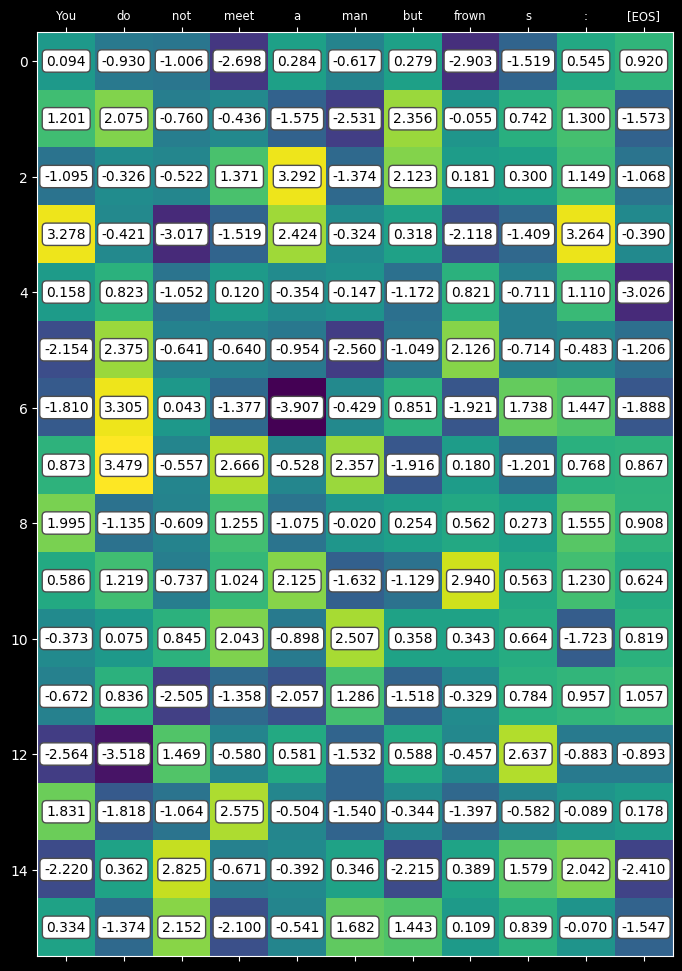

In [6]:
plt.rcParams["figure.figsize"] = (12,12)

# Example Sentence
df = pd.read_csv("../data/shk2mod.csv", index_col=0)
df.drop("id", axis=1, inplace=True)                                  
d = df.to_numpy()
src_toy = d[0:1,0] 

# Encoding src
src_id_toy = shakespeare.EncodeAsIds(list(src_toy))
src_id_toy = [src_processing(id, 256) for id in src_id_toy] 

# Tokenized src
src_toy_tok = to_tokens(src_toy, shakespeare, 256, "src")

# Moving everything to torch tensors
src_id_toy = torch.tensor(src_id_toy)

# Embeddings over time
src_embs = []

for i in range(200):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(0), map_location=torch.device('cpu')))
    # Embeddings as the model is trained
    src_embs.append(model.src_token_emb(src_id_toy) + model.src_pos_emb(torch.arange(256, device="cpu").unsqueeze(0)))

# Embeddings over time
for i in range(0, 455):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(i), map_location=torch.device('cpu')))
    # Embeddings as the model is trained
    src_embs.append(model.src_token_emb(src_id_toy) + model.src_pos_emb(torch.arange(256, device="cpu").unsqueeze(0)))

for i in range(200):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(454), map_location=torch.device('cpu')))
    # Embeddings as the model is trained
    src_embs.append(model.src_token_emb(src_id_toy) + model.src_pos_emb(torch.arange(256, device="cpu").unsqueeze(0)))

# Create the animation
ani = animate_emb(src_embs, src_toy_tok[:11], 11)

# Save the animation
ani.save('./media/videos/animations/FinalEmbs.mp4', writer='ffmpeg', fps=60, dpi=300)